In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import Counter
import pickle as pkl
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, Dataset, SubsetRandomSampler, random_split

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

from torchtext.vocab import Vocab

from torch.nn import TransformerEncoder, TransformerEncoderLayer

import math

from einops import rearrange


In [3]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [4]:
class Identity(nn.Module):
    def __init__(self):
        pass
    
    def forward(self, x):
        return x


class MusicTransformer(nn.Module):
    def __init__(self, vocab_size, vec_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, max_seq_length, pos_dropout, trans_dropout):
        super().__init__()
        self.d_model = d_model
        self.embed_src = nn.Linear(vec_size, d_model)
#         self.embed_src = Identity()
        self.embed_tgt = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, pos_dropout, max_seq_length)

        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, trans_dropout)
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, src, tgt, src_key_padding_mask = None, tgt_key_padding_mask = None, memory_key_padding_mask = None, tgt_mask = None):
        src = rearrange(src, 'n s f -> s n f')
        tgt = rearrange(tgt, 'n t -> t n')
        src = self.pos_enc(self.embed_src(src) * math.sqrt(self.d_model))
        tgt = self.pos_enc(self.embed_tgt(tgt) * math.sqrt(self.d_model))

        output = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_key_padding_mask,
                                  tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask)
        output = rearrange(output, 't n e -> n t e')
        return self.fc(output)

In [5]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device("cpu")
# device = torch.device("cpu")

In [6]:
class Vec21Dataset(Dataset):
    def __init__(self, note_vec_seq, chord_seq, vocab):
        'Initialization'
        self.note_vec_seq = note_vec_seq
        self.chord_seq = chord_seq
        self.vocab = vocab

    def __len__(self):
        'Get the total length of the dataset'
        return len(self.note_vec_seq)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        
        
        return self.note_vec_seq[index], self.vec_encode(self.chord_seq[index])
    
    def encode(self, x):
        return self.vocab.stoi[x]


    def vec_encode(self, x):
        return np.vectorize(self.encode)(x)
    

    def decode(self, x):
        return self.vocab.itos[x]


    def vec_decode(self, x):
        return np.vectorize(self.decode)(x)
    

In [7]:
class TransVecDataset(Vec21Dataset):
    def __init__(self, note_vec_seq, chord_seq, vocab, src_key_padding_mask, trg_key_padding_mask):
        'Initialization'
        self.note_vec_seq = note_vec_seq
        self.chord_seq = chord_seq
        self.vocab = vocab
        self.src_key_padding_mask = src_key_padding_mask
        self.trg_key_padding_mask = trg_key_padding_mask

    def __len__(self):
        'Get the total length of the dataset'
        return len(self.note_vec_seq)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        
        
        return self.note_vec_seq[index], self.vec_encode(self.chord_seq[index]), self.src_key_padding_mask[index], self.trg_key_padding_mask[index]

In [8]:
data = pkl.load(open('haydn_reduced_seq2seq_4mm_new.pkl',"rb"))

note_seq, chord_seq = [],[]
max_seq_len = 0
data_num = 0
for file in data:
    data_num += len(file)
    for window in file:
        note_seq.append(window[0])
        chord_seq.append(window[1])
        max_seq_len = max(max_seq_len, len(window[1]), len(window[0]))

In [9]:
note_padding_vec = np.full(len(note_seq[0][0]), -1).reshape(1,-1) # should be 45; not sure if -1 is good
note_ending_vec = np.ones(len(note_seq[0][0])).reshape(1,-1) # should be 45
note_starting_vec = np.zeros(len(note_seq[0][0])).reshape(1,-1) # should be 45

chord_start = "<sos>"
chord_padding = "<pad>"
chord_end = "<eos>"

padded_note_seq = []
padded_chord_seq = []

src_key_padding_masks = []
trg_key_padding_masks = []

for i in range(len(note_seq)):
    len_diff = max_seq_len - len(note_seq[i])
    
    src_key_padding_masks.append([False for _ in range(len(note_seq[i])+2)] + [True for _ in range(len_diff)])

    temp_note_vec = np.vstack((note_starting_vec, np.array(note_seq[i]), note_ending_vec, np.repeat(note_padding_vec, len_diff , axis = 0)))
    padded_note_seq.append(temp_note_vec)
    
    trg_key_padding_masks.append([False for _ in range(len(chord_seq[i])+2)] + [True for _ in range(len_diff)])
    temp_chord_vec = np.hstack((chord_start, np.array(chord_seq[i]), chord_end, np.repeat(chord_padding, len_diff , axis = 0)))
    padded_chord_seq.append(temp_chord_vec)

src_key_padding_masks = np.array(src_key_padding_masks)
trg_key_padding_masks = np.array(trg_key_padding_masks)

In [10]:
stacked_note_seq = np.stack(padded_note_seq, axis = 0)
stacked_chord_seq = np.vstack(padded_chord_seq)

In [11]:
SEED = 0
VAL_SIZE = 0.2
TEST_SIZE = 0.2

In [12]:
note_vec = np.asarray(stacked_note_seq, dtype = np.float32)

In [13]:
chord_vocab = Vocab(Counter(list(stacked_chord_seq.flatten())))

In [14]:
vec_size = note_vec.shape[-1]
vocab_size = len(chord_vocab.stoi)

In [15]:
# note_train, note_test, chord_train, chord_test \
#     = train_test_split((note_vec, src_key_padding_masks), stacked_chord_seq, test_size=TEST_SIZE, random_state=SEED)

# note_train, note_val, chord_train, chord_val \
#     = train_test_split(note_vec, stacked_chord_seq, test_size= VAL_SIZE/ (1-TEST_SIZE), random_state=SEED)

In [16]:
# train_dataset = Vec21Dataset(note_train, chord_train, chord_vocab)
# val_dataset = Vec21Dataset(note_val, chord_val, chord_vocab)
# test_dataset = Vec21Dataset(note_test, chord_test, chord_vocab)


dt = TransVecDataset(note_vec, stacked_chord_seq, chord_vocab, src_key_padding_masks, trg_key_padding_masks)

train_len = int(len(dt)*0.6)
val_len = int(len(dt)*0.2)
test_len = len(dt) - train_len - val_len
train_dataset, val_dataset, test_dataset = random_split(dt, [train_len, val_len, test_len], 
#                                                         generator=torch.Generator().manual_seed(SEED)
                                                       )

In [17]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size = batch_size, drop_last = True)
val_loader = DataLoader(val_dataset, batch_size =  batch_size, drop_last = True)
test_loader =  DataLoader(test_dataset, batch_size =  batch_size, drop_last = True)

In [18]:
input_size = vec_size
emb_size = vec_size
encoder_hidden_size = 128
decoder_hidden_size = 128
encoder_dropout = 0.5
decoder_dropout = 0.5
n_layers = 2
output_size = vocab_size
model_type = "LSTM"
d_model = 48
nhead = 4
num_encoder_layers = 6
num_decoder_layers = 6
dim_feedforward = 1024
pos_dropout = 0.2
trans_dropout = 0.2

# model = nn.Transformer(d_model = vec_size, nhead = 5).to(device)
# chord_emb = nn.Embedding(vocab_size, vec_size).to(device)

model = MusicTransformer(vocab_size, 
                         vec_size,
                         d_model, 
                         nhead, 
                         num_encoder_layers, 
                         num_decoder_layers, 
                         dim_feedforward, 
                         max_seq_len + 2, 
                         pos_dropout, 
                         trans_dropout).to(device)

In [19]:
criterion = nn.CrossEntropyLoss(ignore_index = chord_vocab.stoi["<pad>"])
# optimizer = optim.AdamW(model.parameters(), lr = 1e-3)
optimizer = optim.SGD(model.parameters(), lr = 1e-3, momentum=0.9, weight_decay=5e-4)

In [20]:
def gen_nopeek_mask(length):
    mask = rearrange(torch.triu(torch.ones(length, length)) == 1, 'h w -> w h')
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))

    return mask

In [ ]:
epochs = 300



train_losses = []
val_losses = []

for epoch in range(1,epochs+1):
    total_loss = 0
    
    model.train()
    train_pgbar = tqdm(train_loader)
    for idx, (note, chord, src_pad_mask, trg_pad_mask) in enumerate(train_pgbar):
        chord = chord.long().to(device)
        
        target = chord[:,:-1].to(device)
        nopeek_mask = gen_nopeek_mask(target.shape[1]).to(device)
        gt = chord[:, 1:]
        note = note.to(device)
        src_pad_mask = src_pad_mask.to(device)
        trg_pad_mask = trg_pad_mask[:,:-1].to(device)
        memory_key_padding_mask = src_pad_mask.clone()
        
        pred = model(note, target, 
                     tgt_mask = nopeek_mask, 
                     src_key_padding_mask = src_pad_mask, 
                     tgt_key_padding_mask = trg_pad_mask,
                     memory_key_padding_mask=memory_key_padding_mask)

        pred = pred.permute(0,2,1)
        loss = criterion(pred, gt)

        optimizer.zero_grad()
        if loss.item() != 0:
            loss.backward()         
            optimizer.step()

        train_pgbar.set_postfix({'Epoch': epoch, 'Train Loss': "{:.5f}".format(loss.item())})
        total_loss += loss.item()
    
    print("Total Training Loss: %.2f" % total_loss)
    train_losses.append(total_loss/len(train_loader))
    total_loss = 0
    
    model.eval()
    val_pgbar = tqdm(val_loader)
    for idx, (note, chord, src_pad_mask, trg_pad_mask) in enumerate(val_pgbar):
        chord = chord.long().to(device)

        target = chord[:,:-1].to(device)
        nopeek_mask = gen_nopeek_mask(target.shape[1]).to(device)
        gt = chord[:, 1:]
        note = note.to(device)
        src_pad_mask = src_pad_mask.to(device)
        trg_pad_mask = trg_pad_mask[:,:-1].to(device)
        memory_key_padding_mask = src_pad_mask.clone()
        
        pred = model(note, target, 
                     tgt_mask = nopeek_mask, 
                     src_key_padding_mask = src_pad_mask, 
                     tgt_key_padding_mask = trg_pad_mask,
                     memory_key_padding_mask=memory_key_padding_mask)

        pred = pred.permute(0,2,1)
        loss = criterion(pred, gt)

        val_pgbar.set_postfix({'Epoch': epoch, 'Val Loss': "{:.5f}".format(loss.item())})
        total_loss += loss.item()
    print("Total Validation Loss: %.2f" % total_loss)
    val_losses.append(total_loss/len(val_loader))
    if epoch % 10 == 0:
        torch.save(model.state_dict(), "haydn_reduced_trans/ckpt" + str(epoch) + ".sdict")


Total Training Loss: 1282.04



Total Validation Loss: 372.61



Total Training Loss: 1068.82



Total Validation Loss: 325.19



Total Training Loss: 958.35



Total Validation Loss: 296.38



Total Training Loss: 889.09



Total Validation Loss: 277.56



Total Training Loss: 840.96



Total Validation Loss: 261.97



Total Training Loss: 800.09



Total Validation Loss: 247.41



Total Training Loss: 761.51



Total Validation Loss: 232.17



Total Training Loss: 723.01



Total Validation Loss: 218.21



Total Training Loss: 687.26



Total Validation Loss: 206.28



Total Training Loss: 656.02



Total Validation Loss: 196.32



Total Training Loss: 629.55



Total Validation Loss: 188.24



Total Training Loss: 606.20



Total Validation Loss: 181.52



Total Training Loss: 586.38



Total Validation Loss: 175.92



Total Training Loss: 569.14



Total Validation Loss: 171.00



Total Training Loss: 554.36



Total Validation Loss: 167.21



Total Training Loss: 541.55



Total Validation Loss: 163.65



Total Training Loss: 530.21



Total Validation Loss: 160.87



Total Training Loss: 520.50



Total Validation Loss: 158.09



Total Training Loss: 511.45



Total Validation Loss: 155.78



Total Training Loss: 504.09



Total Validation Loss: 153.65



Total Training Loss: 496.78



Total Validation Loss: 151.61



Total Training Loss: 490.28



Total Validation Loss: 149.90



Total Training Loss: 484.01



Total Validation Loss: 148.26



Total Training Loss: 478.51



Total Validation Loss: 146.81



Total Training Loss: 473.54



Total Validation Loss: 145.28



Total Training Loss: 469.03



Total Validation Loss: 144.12



Total Training Loss: 464.79



Total Validation Loss: 142.76



Total Training Loss: 460.89



Total Validation Loss: 141.67



Total Training Loss: 457.22



Total Validation Loss: 140.65



Total Training Loss: 453.22



Total Validation Loss: 139.69



Total Training Loss: 449.78



Total Validation Loss: 138.62



Total Training Loss: 446.74



Total Validation Loss: 137.77



Total Training Loss: 443.29



Total Validation Loss: 136.70



Total Training Loss: 440.57



Total Validation Loss: 135.94



Total Training Loss: 438.34



Total Validation Loss: 135.23



Total Training Loss: 435.04



Total Validation Loss: 134.45



Total Training Loss: 432.45



Total Validation Loss: 133.78



Total Training Loss: 430.43



Total Validation Loss: 132.89



Total Training Loss: 428.29



Total Validation Loss: 132.24



Total Training Loss: 425.89



Total Validation Loss: 131.47



Total Training Loss: 423.60



Total Validation Loss: 131.15



Total Training Loss: 421.33



Total Validation Loss: 130.38



Total Training Loss: 418.99



Total Validation Loss: 129.70



Total Training Loss: 417.34



Total Validation Loss: 129.12



Total Training Loss: 415.79



Total Validation Loss: 128.83



Total Training Loss: 413.80



Total Validation Loss: 128.10



Total Training Loss: 411.98



Total Validation Loss: 127.61



Total Training Loss: 410.74



Total Validation Loss: 127.11



Total Training Loss: 408.87



Total Validation Loss: 126.64



Total Training Loss: 407.17



Total Validation Loss: 126.24



Total Training Loss: 405.95



Total Validation Loss: 125.52



Total Training Loss: 404.54



Total Validation Loss: 125.15



Total Training Loss: 403.08



Total Validation Loss: 124.77



Total Training Loss: 401.75



Total Validation Loss: 124.49



Total Training Loss: 400.17



Total Validation Loss: 124.06



Total Training Loss: 398.49



Total Validation Loss: 123.79



Total Training Loss: 397.59



Total Validation Loss: 123.33


In [65]:
import matplotlib.pyplot as plt

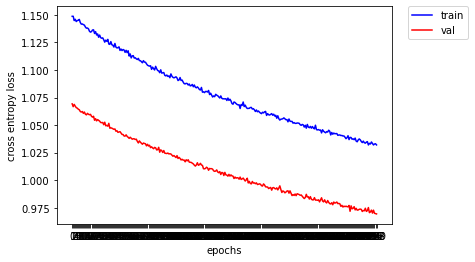

In [66]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(train_losses, color = "b", label = "train")
plt.plot(val_losses, color = "r", label = "val")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_xlabel('epochs')
ax.set_ylabel('cross entropy loss') 
xint = range(len(train_losses))

plt.xticks(xint)
plt.show()

In [67]:
# model.load_state_dict(torch.load("sears_reduced_trans/ckpt300.sdict"))

In [68]:
model.eval()
all_pred2 = []
all_label2 = []
pad_idx = chord_vocab.stoi["<sos>"]
for idx, (note, chord, src_pad_mask, trg_pad_mask) in enumerate(tqdm(test_loader)):
    
        chord = chord.long().to(device)
        target = chord[:,:-1].to(device)
        nopeek_mask = gen_nopeek_mask(target.shape[1]).to(device)
        gt = chord[:, 1:]
        note = note.to(device)
        src_pad_mask = src_pad_mask.to(device)
        trg_pad_mask = trg_pad_mask[:,:-1].to(device)
        memory_key_padding_mask = src_pad_mask.clone()
        
#         pred = model(note, target, 
#                      tgt_mask = nopeek_mask, 
#                      src_key_padding_mask = src_pad_mask, 
#                      tgt_key_padding_mask = trg_pad_mask,
#                      memory_key_padding_mask=memory_key_padding_mask)
        
        
        output = torch.full(chord.shape, pad_idx).to(device)
        for i in range(len(target[0])):
        
            pred = model(note, output[:,:-1], tgt_mask = nopeek_mask, 
                     src_key_padding_mask = src_pad_mask, 
                     tgt_key_padding_mask = trg_pad_mask,
                     memory_key_padding_mask=memory_key_padding_mask)
            
            pred = pred.argmax(axis = -1)
            output[:, i+1] = pred[:, i]
#             print(output[0])
        
#         pred = pred.detach().cpu().numpy().argmax(axis = -1)
        
        label = chord.detach().cpu().numpy()
#         pred = np.hstack((np.full((len(pred),1), chord_vocab.stoi["<sos>"]),pred))
#         print(pred)
        preds = output.detach().cpu().numpy()
        all_pred2.append(dt.vec_decode(preds))
        all_label2.append(dt.vec_decode(label))

In [71]:
all_pred2 = np.vstack(all_pred2)
all_label2 = np.vstack(all_label2)

In [72]:
all_pred2[0]

array(['<sos>', 'G# major', 'G# major', 'G# major', 'G# major',
       'G# major', 'G# major', 'G# major', 'G# major', 'G# major',
       'G# major', 'G# major', 'G# major', 'G# major', 'G# major',
       'G# major', 'G# major', 'G# major', 'G# major', 'G# major',
       'G# major', 'G# major', 'G# major', 'G# major', 'G# major',
       'G# major', 'G# major', 'G# major', 'G# major', 'G# major',
       'G# major', 'G# major', 'G# major', 'G# major', 'G# major',
       'G# major', 'G# major', 'G# major', 'G# major', 'G# major',
       'G# major', 'G# major', 'G# major', 'G# major', 'G# major',
       'G# major', 'G# major', 'G# major', 'G# major', 'G# major',
       'G# major', 'G# major', 'G# major', 'G# major', 'G# major',
       'G# major', 'G# major', 'G# major', 'G# major', 'G# major',
       'G# major', 'G# major', 'G# major', 'G# major', 'G# major',
       'G# major'], dtype='<U26')

In [73]:
all_label2[0]

array(['<sos>', 'G# major', 'G# major', 'G# major', 'G# major',
       'G# major', 'G# major', 'G# major', 'D# dominant seventh',
       'D# dominant seventh', 'D# dominant seventh',
       'D# dominant seventh', 'D# dominant seventh',
       'D# dominant seventh', 'D# dominant seventh', 'G# major',
       'G# major', 'G# major', 'G# major', 'G# major', 'G# major',
       'G# major', 'A# minor', 'A# minor', 'A# minor', 'A# minor',
       'A# minor', 'A# minor', 'A# minor', 'A# minor', 'A# minor',
       'A# major', 'A# major', '<eos>', '<pad>', '<pad>', '<pad>',
       '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',
       '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',
       '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',
       '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',
       '<pad>'], dtype='<U27')

In [74]:
decoded_preds = all_pred2
decoded_chords = all_label2

In [75]:
mask = (decoded_preds != "<sos>") & (decoded_preds != "<eos>") & (decoded_preds != "<pad>")
masked_preds = decoded_preds[mask]
masked_chords = decoded_chords[mask]

print(np.sum(masked_preds == masked_chords) / len(masked_chords))

# mask = (decoded_chords != "<sos>") & (decoded_chords != "<eos>") & (decoded_chords != "<pad>")
# masked_preds = decoded_preds[mask]
# masked_chords = decoded_chords[mask]

# print(np.sum(masked_preds == masked_chords) / len(masked_chords))

0.1693221901555235


In [76]:
print(masked_chords)

['G# major' 'G# major' 'G# major' ... '<pad>' '<pad>' '<pad>']


In [77]:
masked_preds == masked_chords

array([ True,  True,  True, ..., False, False, False])

In [78]:
# SEPERATE EVALUATION OF ROOT AND QUALITY AFTER DECODING
# seperate all pred 
root_preds = decoded_preds.copy()
quality_preds = decoded_preds.copy()
for r_id in range(decoded_preds.shape[0]):
    for c_id in range(decoded_preds.shape[1]):
        sp = decoded_preds[r_id, c_id].split(' ')
        root_preds[r_id, c_id] = sp[0]
        quality_preds[r_id, c_id] = ' '.join(sp[1:])
    
root_labels = decoded_chords.copy()
quality_labels = decoded_chords.copy()
for r_id in range(decoded_chords.shape[0]):
    for c_id in range(decoded_chords.shape[1]):
        sp = decoded_chords[r_id, c_id].split(' ')
        root_labels[r_id, c_id] = sp[0]
        quality_labels[r_id, c_id] = ' '.join(sp[1:])
# # seperate all lable 
# root_labels = []
# quality_labels = []
# for c in decoded_chords:
#     sp = c.split(' ')
#     root_labels.append(sp[0])
#     quality_labels.append(' '.join(sp[1:]))
    
# root_labels = np.asarray(root_labels)
# quality_labels = np.asarray(quality_labels)

In [79]:
mask = (root_preds != "<sos>") & (root_preds != "<eos>") & (root_preds != "<pad>")
root_preds = root_preds[mask]
quality_preds = quality_preds[mask]
root_label = root_labels[mask]
quality_labels = quality_labels[mask]

In [80]:
np.sum(root_preds == root_label) / len(root_preds)

0.1821789321789322

In [81]:
np.sum(quality_preds == quality_labels) / len(quality_preds)

0.2157086740420074

In [ ]:
torch.save(model.state_dict(), "bach_reduced_10warm80epoch50post_s2s.sdict")

In [ ]:
# EVALUATE root AFTER DECODING
sum(1 for x,y in zip(root_preds, root_labels) if x == y) / len(root_labels)

In [ ]:
# EVALUATE quality AFTER DECODING
sum(1 for x,y in zip(quality_preds, quality_labels) if x == y) / len(quality_labels)

In [ ]:
co = Counter(chords)

In [ ]:
most_common_chord = list(list(zip(*co.most_common(20)))[0])

In [ ]:
for i in range(len(decoded_preds)):
    if decoded_preds[i] not in most_common_chord:
        decoded_preds[i] = "others"
    if decoded_chords[i] not in most_common_chord:
        decoded_chords[i] = "others"

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sn

In [ ]:
cm = confusion_matrix(decoded_chords, decoded_preds, normalize = "true", labels = most_common_chord + ["others"])

In [ ]:
fig, ax = plt.subplots(figsize=(13,10)) 

sn.heatmap(cm, annot=False)
ax.set_xticklabels(most_common_chord + ["others"])
ax.set_yticklabels(most_common_chord + ["others"])
plt.yticks(rotation=0) 
plt.xticks(rotation="vertical") 
plt.show()
fig.savefig("confusion_bachhaydn_baseline.pdf", format = "pdf")

In [ ]:
torch.save(model.state_dict(), "baseline_bach_and_haydn.pt")

In [ ]:
symbol, num = list(zip(*co.most_common(50)))
symbol = list(symbol)
num = list(num)

In [ ]:
symbol += ['others']
num += [np.sum(list(co.values())) - np.sum(num)]

In [ ]:
num/=np.sum(num)

In [ ]:
plt.subplots(figsize=(13,10)) 
x_pos = [i for i, _ in enumerate(symbol)]

plt.bar(x_pos, num)
plt.xlabel("Chord Symbol")
plt.ylabel("Occurance")
plt.title("bach chorales Chord Distribution")

plt.xticks(x_pos, symbol, rotation = "vertical")

plt.show()